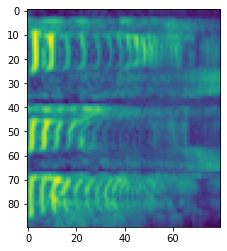

In [10]:
import os
import pickle
import torch
import numpy as np
from math import ceil
from config import Config
from model_vc import Generator

#Temporary:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Use gpu or cpu

def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

G = Generator(32,256,512,32).eval().to(device)

if torch.cuda.is_available():
    g_checkpoint = torch.load(Config.path_autovc)
else: #load for cpu: 
    g_checkpoint = torch.load(Config.path_autovc, map_location=torch.device('cpu'))

G.load_state_dict(g_checkpoint['model'])

metadata = pickle.load(open('metadata.pkl', "rb"))

metadata

# import matplotlib.pyplot as plt

# plt.imshow(metadata[1])
plt.imshow(metadata[0][2])
plt.show()

# metadata

In [3]:

spect_vc = []

for sbmt_i in metadata:
             
    x_org = sbmt_i[2]
    x_org, len_pad = pad_seq(x_org)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    emb_org = torch.from_numpy(sbmt_i[1][np.newaxis, :]).to(device)
    
    for sbmt_j in metadata:
                   
        emb_trg = torch.from_numpy(sbmt_j[1][np.newaxis, :]).to(device)
        
        with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
            
        if len_pad == 0:
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
        
        spect_vc.append( ('{}x{}'.format(sbmt_i[0], sbmt_j[0]), uttr_trg) )

spect_vc
        


[('p225xp225',
  array([[0.38280225, 0.32192808, 0.27241036, ..., 0.18827905, 0.18116058,
          0.1747563 ],
         [0.37740552, 0.30501324, 0.31424847, ..., 0.23313932, 0.18586268,
          0.14988668],
         [0.38855177, 0.28357583, 0.2739416 , ..., 0.13206439, 0.10279436,
          0.10369423],
         ...,
         [0.5714353 , 0.6357635 , 0.56166023, ..., 0.21222183, 0.19688345,
          0.18200685],
         [0.50516725, 0.50225824, 0.4819557 , ..., 0.18236056, 0.16847153,
          0.15469943],
         [0.44893783, 0.4405584 , 0.4609493 , ..., 0.14624402, 0.1329226 ,
          0.13138215]], dtype=float32)),
 ('p225xp228',
  array([[0.4372439 , 0.35739928, 0.30414352, ..., 0.20524147, 0.19167462,
          0.17206722],
         [0.44479772, 0.35146442, 0.31340066, ..., 0.23535399, 0.23473117,
          0.22268614],
         [0.4352066 , 0.3636809 , 0.34444588, ..., 0.2080974 , 0.19319984,
          0.18029556],
         ...,
         [0.47883365, 0.45897844, 0.497278

In [ ]:


with open('results.pkl', 'wb') as handle:
    pickle.dump(spect_vc, handle)          